<a href="https://colab.research.google.com/github/ArshT/Pytorch_Practice/blob/master/DCGAN_FashionMNIST_Hacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
from os.path import exists

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST

img_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = FashionMNIST(root='./data/', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = FashionMNIST(root='./data/', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100,1024,4,1,0)
        self.deconv1_bn = nn.BatchNorm2d(1024)
        self.deconv2 = nn.ConvTranspose2d(1024,512, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(512)
        self.deconv3 = nn.ConvTranspose2d(512,256, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256,128, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(128)
        self.deconv5 = nn.ConvTranspose2d(128, 1, 4, 2, 1)

    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.leaky_relu(self.deconv1_bn(self.deconv1(input)), 0.2)
        x = F.leaky_relu(self.deconv2_bn(self.deconv2(x)), 0.2)
        x = F.leaky_relu(self.deconv3_bn(self.deconv3(x)), 0.2)
        x = F.leaky_relu(self.deconv4_bn(self.deconv4(x)), 0.2)
        x = torch.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, 4, 2, 1)
        self.conv2 = nn.Conv2d(128,256, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256,512, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512,1024, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(1024)
        self.conv5 = nn.Conv2d(1024, 1, 4, 1, 0)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))
        return x
    
generator = Generator()
discriminator = Discriminator()

device = torch.device("cuda:0" if True and torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

print(generator)
print("")
print(discriminator)

Generator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

Discriminator(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=

In [8]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Training ...
Batch: 50 Generator Loss: 0.9656356298923492 Discriminator Loss: 0.5727692639827728
Batch: 100 Generator Loss: 0.955977407693863 Discriminator Loss: 0.5849709260463715
Batch: 150 Generator Loss: 0.9629199707508087 Discriminator Loss: 0.5761450219154358
Batch: 200 Generator Loss: 0.9703484034538269 Discriminator Loss: 0.5796499967575073
Batch: 250 Generator Loss: 0.959170868396759 Discriminator Loss: 0.5750373136997223
Batch: 300 Generator Loss: 0.9471336460113525 Discriminator Loss: 0.5832504510879517
Batch: 350 Generator Loss: 0.9504503524303436 Discriminator Loss: 0.5821017003059388
Batch: 400 Generator Loss: 0.9418135273456574 Discriminator Loss: 0.5905327129364014
Batch: 450 Generator Loss: 0.938341783285141 Discriminator Loss: 0.5910080945491791


Epoch [1 / 20] average loss generator vs. discrim.: 0.954805 vs. 0.581312

Batch: 50 Generator Loss: 0.962350401878357 Discriminator Loss: 0.5829376959800721
Batch: 100 Generator Loss: 0.9514834260940552 Discriminator Loss: 0.5794406247138977
Batch: 150 Generator Loss: 0.9431768703460693 Discriminator Loss: 0.5781738042831421
Batch: 200 Generator Loss: 0.9470418834686279 Discriminator Loss: 0.5853145813941956
Batch: 250 Generator Loss: 0.9576627469062805 Discriminator Loss: 0.5797531414031982
Batch: 300 Generator Loss: 0.9577068626880646 Discriminator Loss: 0.5783462476730347
Batch: 350 Generator Loss: 0.9445516908168793 Discriminator Loss: 0.5850972497463226
Batch: 400 Generator Loss: 0.937626758813858 Discriminator Loss: 0.5896055436134339
Batch: 450 Generator Loss: 0.9565846550464631 Discriminator Loss: 0.579177211523056


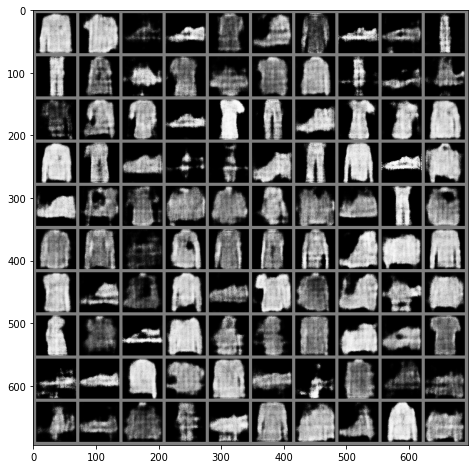

Epoch [2 / 20] average loss generator vs. discrim.: 0.950653 vs. 0.581957

Batch: 50 Generator Loss: 0.9672322809696198 Discriminator Loss: 0.5761144137382508
Batch: 100 Generator Loss: 0.9570254838466644 Discriminator Loss: 0.5735889935493469
Batch: 150 Generator Loss: 0.967587616443634 Discriminator Loss: 0.5690088999271393
Batch: 200 Generator Loss: 0.9645408689975739 Discriminator Loss: 0.5762885963916778
Batch: 250 Generator Loss: 0.9579515266418457 Discriminator Loss: 0.5772435462474823
Batch: 300 Generator Loss: 0.951598242521286 Discriminator Loss: 0.5785827922821045
Batch: 350 Generator Loss: 0.9598795318603516 Discriminator Loss: 0.5732592344284058
Batch: 400 Generator Loss: 0.9702091038227081 Discriminator Loss: 0.5735833787918091
Batch: 450 Generator Loss: 0.9611235034465789 Discriminator Loss: 0.5734955441951751


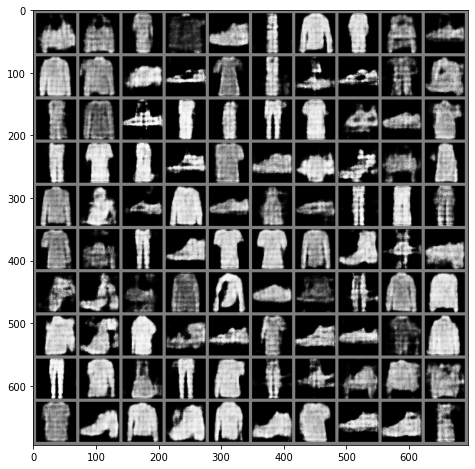

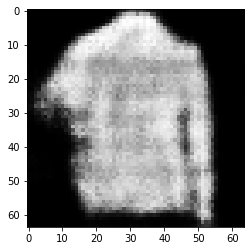

Epoch [3 / 20] average loss generator vs. discrim.: 0.962941 vs. 0.574348

Batch: 50 Generator Loss: 0.995085871219635 Discriminator Loss: 0.5809078711271286
Batch: 100 Generator Loss: 0.97122709274292 Discriminator Loss: 0.5715115451812744
Batch: 150 Generator Loss: 0.9904026901721954 Discriminator Loss: 0.5674743711948395
Batch: 200 Generator Loss: 0.9725075256824494 Discriminator Loss: 0.5682390308380127
Batch: 250 Generator Loss: 0.9882148051261902 Discriminator Loss: 0.5655416941642761
Batch: 300 Generator Loss: 0.9716971647739411 Discriminator Loss: 0.5736145055294037
Batch: 350 Generator Loss: 0.979375364780426 Discriminator Loss: 0.5634746038913727
Batch: 400 Generator Loss: 0.9803029000759125 Discriminator Loss: 0.5651271414756774
Batch: 450 Generator Loss: 0.9802503645420074 Discriminator Loss: 0.5704382848739624


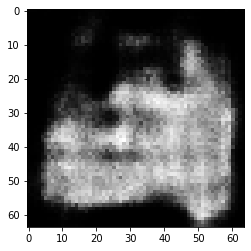

Epoch [4 / 20] average loss generator vs. discrim.: 0.981363 vs. 0.569276

Batch: 50 Generator Loss: 1.009078940153122 Discriminator Loss: 0.5591410839557648
Batch: 100 Generator Loss: 1.003781201839447 Discriminator Loss: 0.5569055008888245
Batch: 150 Generator Loss: 1.0098978328704833 Discriminator Loss: 0.5603273296356202
Batch: 200 Generator Loss: 1.001113359928131 Discriminator Loss: 0.558186948299408
Batch: 250 Generator Loss: 1.0026595067977906 Discriminator Loss: 0.5644219589233398
Batch: 300 Generator Loss: 1.002849668264389 Discriminator Loss: 0.5559468293190002
Batch: 350 Generator Loss: 0.9876465511322021 Discriminator Loss: 0.568336797952652
Batch: 400 Generator Loss: 0.9981103360652923 Discriminator Loss: 0.5610698056221008
Batch: 450 Generator Loss: 1.0024050545692444 Discriminator Loss: 0.5605227255821228


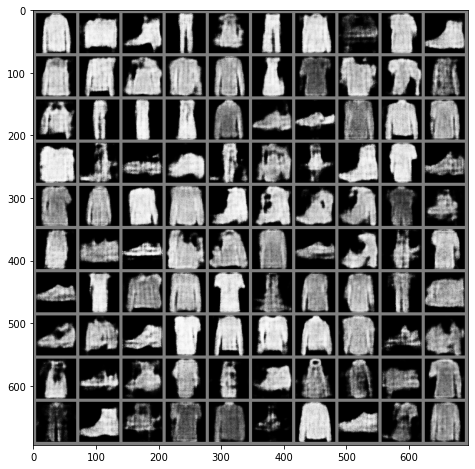

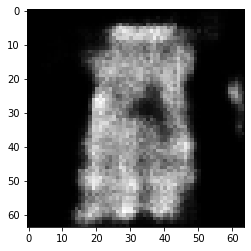

Epoch [5 / 20] average loss generator vs. discrim.: 1.003007 vs. 0.560811

Batch: 50 Generator Loss: 1.0292971765995025 Discriminator Loss: 0.5491167080402374
Batch: 100 Generator Loss: 1.0267288863658905 Discriminator Loss: 0.5537025141716003
Batch: 150 Generator Loss: 1.0255494868755342 Discriminator Loss: 0.5439154821634292
Batch: 200 Generator Loss: 1.0337605237960816 Discriminator Loss: 0.540555156469345
Batch: 250 Generator Loss: 1.031952919960022 Discriminator Loss: 0.5608505880832673
Batch: 300 Generator Loss: 1.0377166771888733 Discriminator Loss: 0.5512710344791413
Batch: 350 Generator Loss: 1.026362532377243 Discriminator Loss: 0.5494411599636078
Batch: 400 Generator Loss: 1.040867725610733 Discriminator Loss: 0.5500608342885971
Batch: 450 Generator Loss: 1.0306181120872497 Discriminator Loss: 0.5473073017597199


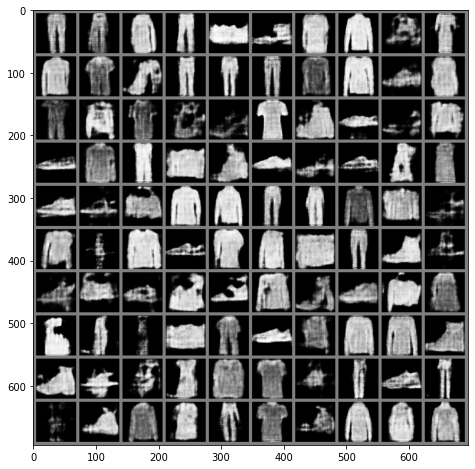

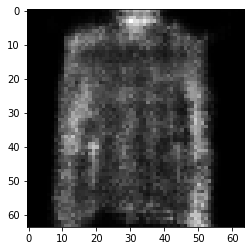

Epoch [6 / 20] average loss generator vs. discrim.: 1.031867 vs. 0.549355

Batch: 50 Generator Loss: 1.0685781955718994 Discriminator Loss: 0.5472049176692962
Batch: 100 Generator Loss: 1.0589410519599916 Discriminator Loss: 0.5364183735847473
Batch: 150 Generator Loss: 1.067748396396637 Discriminator Loss: 0.5323837631940842
Batch: 200 Generator Loss: 1.0846973025798798 Discriminator Loss: 0.5381474989652634
Batch: 250 Generator Loss: 1.0589450550079347 Discriminator Loss: 0.5409268182516098
Batch: 300 Generator Loss: 1.0675634562969207 Discriminator Loss: 0.5381308686733246
Batch: 350 Generator Loss: 1.0658930790424348 Discriminator Loss: 0.5433279591798782
Batch: 400 Generator Loss: 1.0644553709030151 Discriminator Loss: 0.5356689029932022
Batch: 450 Generator Loss: 1.0594106709957123 Discriminator Loss: 0.5365081882476807


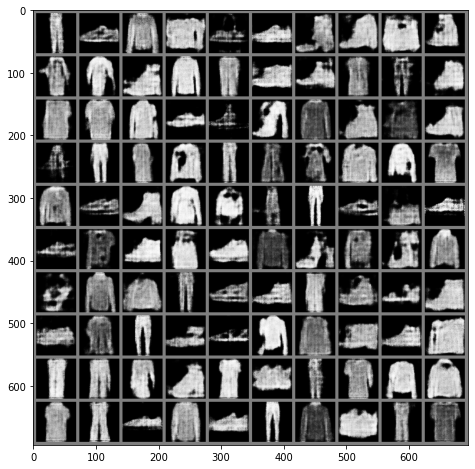

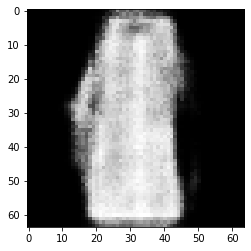

Epoch [7 / 20] average loss generator vs. discrim.: 1.066755 vs. 0.538198

Batch: 50 Generator Loss: 1.1104144334793091 Discriminator Loss: 0.5359035688638687
Batch: 100 Generator Loss: 1.0867602932453155 Discriminator Loss: 0.5263295501470566
Batch: 150 Generator Loss: 1.0942315351963043 Discriminator Loss: 0.5290151935815811
Batch: 200 Generator Loss: 1.0915911543369292 Discriminator Loss: 0.5285772138834
Batch: 250 Generator Loss: 1.0989744436740876 Discriminator Loss: 0.5271825057268142
Batch: 300 Generator Loss: 1.119772218465805 Discriminator Loss: 0.5213830691576004
Batch: 350 Generator Loss: 1.0860889744758606 Discriminator Loss: 0.533025461435318
Batch: 400 Generator Loss: 1.1045397591590882 Discriminator Loss: 0.5187108379602432
Batch: 450 Generator Loss: 1.1048001170158386 Discriminator Loss: 0.5235330671072006


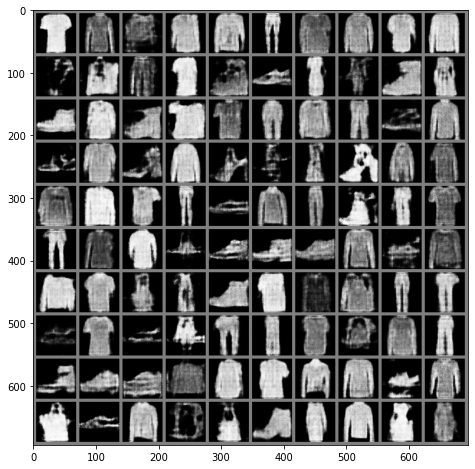

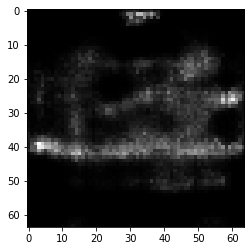

Epoch [8 / 20] average loss generator vs. discrim.: 1.099809 vs. 0.527048

Batch: 50 Generator Loss: 1.1430074214935302 Discriminator Loss: 0.5210809701681137
Batch: 100 Generator Loss: 1.1384604620933532 Discriminator Loss: 0.5104650521278381
Batch: 150 Generator Loss: 1.1408451461791993 Discriminator Loss: 0.5110457444190979
Batch: 200 Generator Loss: 1.157528579235077 Discriminator Loss: 0.5096747833490372
Batch: 250 Generator Loss: 1.154457414150238 Discriminator Loss: 0.5117759031057357
Batch: 300 Generator Loss: 1.156805089712143 Discriminator Loss: 0.5129415333271027
Batch: 350 Generator Loss: 1.1469680988788604 Discriminator Loss: 0.5142059063911438
Batch: 400 Generator Loss: 1.1552335000038148 Discriminator Loss: 0.5047435569763183
Batch: 450 Generator Loss: 1.166476536989212 Discriminator Loss: 0.5136989635229111


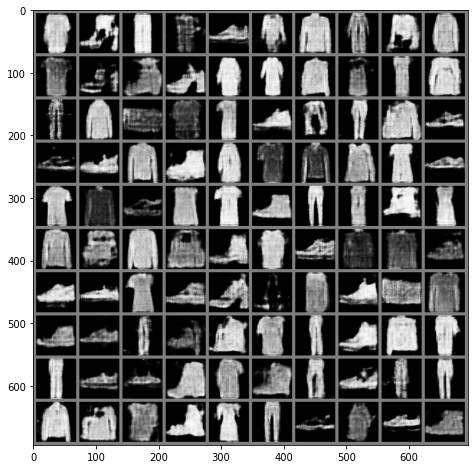

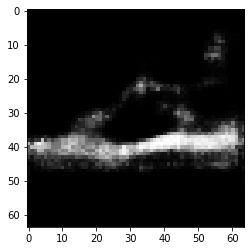

Epoch [9 / 20] average loss generator vs. discrim.: 1.149475 vs. 0.512112

Batch: 50 Generator Loss: 1.1833363771438599 Discriminator Loss: 0.5011189275979996
Batch: 100 Generator Loss: 1.1792693388462068 Discriminator Loss: 0.5047453308105468
Batch: 150 Generator Loss: 1.1665183770656586 Discriminator Loss: 0.5071034264564515
Batch: 200 Generator Loss: 1.2040519905090332 Discriminator Loss: 0.49847898483276365
Batch: 250 Generator Loss: 1.1800323963165282 Discriminator Loss: 0.49746803760528563
Batch: 300 Generator Loss: 1.203616647720337 Discriminator Loss: 0.4957487565279007
Batch: 350 Generator Loss: 1.177960410118103 Discriminator Loss: 0.49816482186317446
Batch: 400 Generator Loss: 1.1985475289821625 Discriminator Loss: 0.48586616158485413
Batch: 450 Generator Loss: 1.1763556385040284 Discriminator Loss: 0.5049120527505875


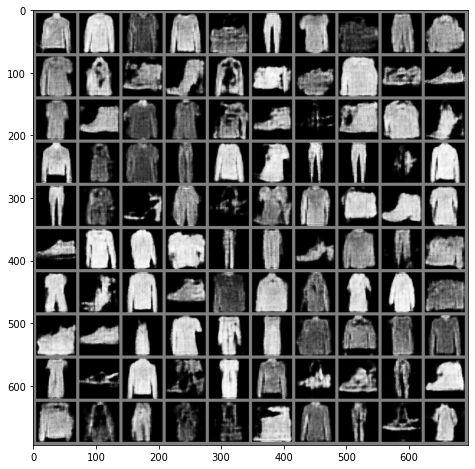

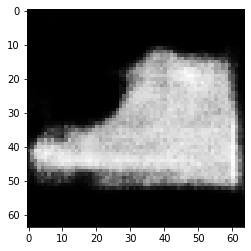

Epoch [10 / 20] average loss generator vs. discrim.: 1.186911 vs. 0.499330

Batch: 50 Generator Loss: 1.220742208957672 Discriminator Loss: 0.4949937552213669
Batch: 100 Generator Loss: 1.2385988712310791 Discriminator Loss: 0.4881669932603836
Batch: 150 Generator Loss: 1.2298196756839752 Discriminator Loss: 0.4755640095472336
Batch: 200 Generator Loss: 1.2328707051277161 Discriminator Loss: 0.490226520895958
Batch: 250 Generator Loss: 1.2385717630386353 Discriminator Loss: 0.47353139638900754
Batch: 300 Generator Loss: 1.2634768438339234 Discriminator Loss: 0.485926530957222
Batch: 350 Generator Loss: 1.2386849057674407 Discriminator Loss: 0.4799033099412918
Batch: 400 Generator Loss: 1.2731715726852417 Discriminator Loss: 0.46520597457885743
Batch: 450 Generator Loss: 1.2456685888767243 Discriminator Loss: 0.47573086857795716


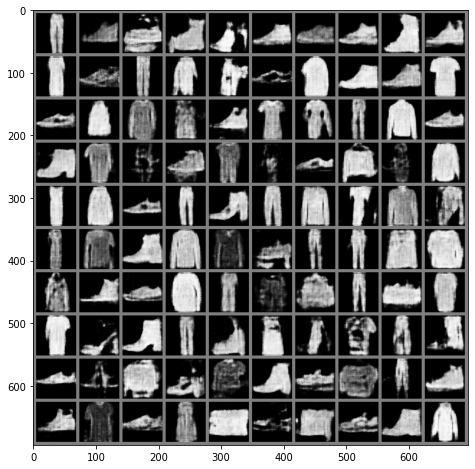

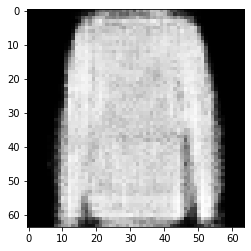

Epoch [11 / 20] average loss generator vs. discrim.: 1.243136 vs. 0.480857

Batch: 50 Generator Loss: 1.2809425055980683 Discriminator Loss: 0.48289397299289705
Batch: 100 Generator Loss: 1.3246317112445831 Discriminator Loss: 0.47056070029735564
Batch: 150 Generator Loss: 1.2937462496757508 Discriminator Loss: 0.46408468902111055
Batch: 200 Generator Loss: 1.2863368570804596 Discriminator Loss: 0.46437713980674744
Batch: 250 Generator Loss: 1.3159018385410308 Discriminator Loss: 0.4649830597639084
Batch: 300 Generator Loss: 1.2643873631954192 Discriminator Loss: 0.47847374856472014
Batch: 350 Generator Loss: 1.3255224335193634 Discriminator Loss: 0.4575150674581528
Batch: 400 Generator Loss: 1.3225280606746674 Discriminator Loss: 0.47183355152606965
Batch: 450 Generator Loss: 1.286528924703598 Discriminator Loss: 0.47117149889469145


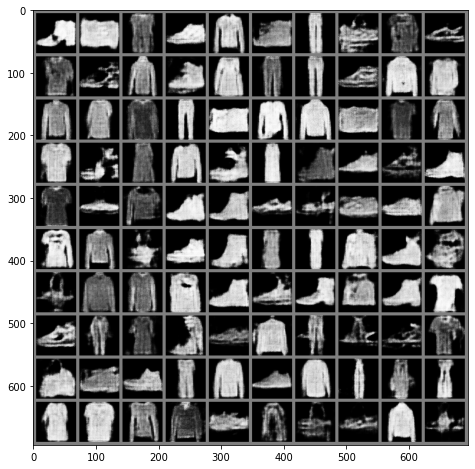

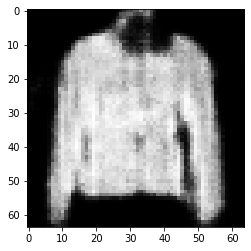

Epoch [12 / 20] average loss generator vs. discrim.: 1.301603 vs. 0.470349

Batch: 50 Generator Loss: 1.3358992958068847 Discriminator Loss: 0.4481485879421234
Batch: 100 Generator Loss: 1.342068884372711 Discriminator Loss: 0.46892105758190156
Batch: 150 Generator Loss: 1.3445619177818298 Discriminator Loss: 0.4483433681726456
Batch: 200 Generator Loss: 1.3730741465091705 Discriminator Loss: 0.46619675993919374
Batch: 250 Generator Loss: 1.3486452734470367 Discriminator Loss: 0.44400650560855864
Batch: 300 Generator Loss: 1.390281879901886 Discriminator Loss: 0.4468035328388214
Batch: 350 Generator Loss: 1.3654830527305604 Discriminator Loss: 0.44826981842517855
Batch: 400 Generator Loss: 1.381590975522995 Discriminator Loss: 0.4424367505311966
Batch: 450 Generator Loss: 1.3551192820072173 Discriminator Loss: 0.45227717101573944


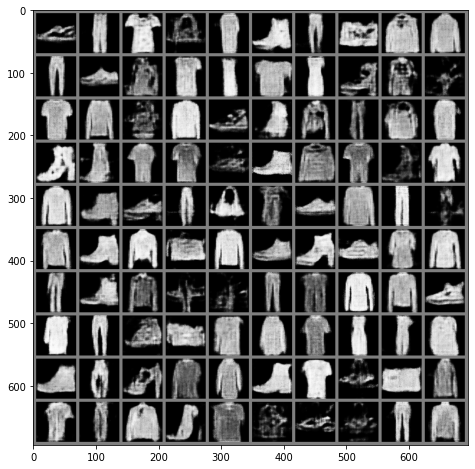

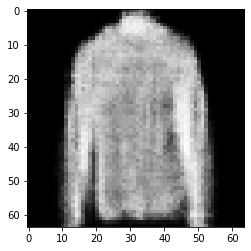

Epoch [13 / 20] average loss generator vs. discrim.: 1.360458 vs. 0.450881

Batch: 50 Generator Loss: 1.432438509464264 Discriminator Loss: 0.44368018686771393
Batch: 100 Generator Loss: 1.4142738020420074 Discriminator Loss: 0.4420838326215744
Batch: 150 Generator Loss: 1.4216481053829193 Discriminator Loss: 0.4382420140504837
Batch: 200 Generator Loss: 1.4377480947971344 Discriminator Loss: 0.43902990520000457
Batch: 250 Generator Loss: 1.4287870848178863 Discriminator Loss: 0.44286669075489044
Batch: 300 Generator Loss: 1.4384287536144256 Discriminator Loss: 0.4377093875408173
Batch: 350 Generator Loss: 1.4470862305164338 Discriminator Loss: 0.42696881890296934
Batch: 400 Generator Loss: 1.4542606663703919 Discriminator Loss: 0.43301533639431
Batch: 450 Generator Loss: 1.4367896866798402 Discriminator Loss: 0.4307706767320633


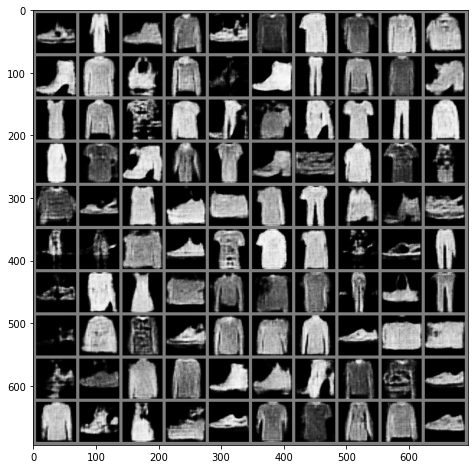

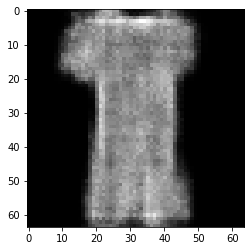

Epoch [14 / 20] average loss generator vs. discrim.: 1.434494 vs. 0.437115

Batch: 50 Generator Loss: 1.5178430783748627 Discriminator Loss: 0.4206256341934204
Batch: 100 Generator Loss: 1.4932702362537384 Discriminator Loss: 0.43028766810894015
Batch: 150 Generator Loss: 1.4753400111198425 Discriminator Loss: 0.42220215559005736
Batch: 200 Generator Loss: 1.5159637081623076 Discriminator Loss: 0.43691511869430544
Batch: 250 Generator Loss: 1.4922775578498841 Discriminator Loss: 0.43816587448120115
Batch: 300 Generator Loss: 1.4841219532489776 Discriminator Loss: 0.40879701912403105
Batch: 350 Generator Loss: 1.5226571226119996 Discriminator Loss: 0.4234709525108337
Batch: 400 Generator Loss: 1.5174556183815002 Discriminator Loss: 0.41217793703079225
Batch: 450 Generator Loss: 1.5153521823883056 Discriminator Loss: 0.4155506020784378


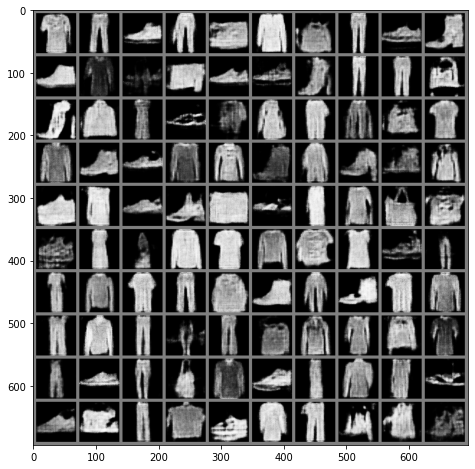

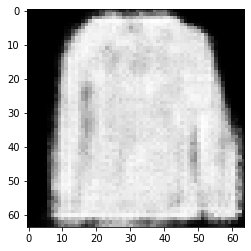

Epoch [15 / 20] average loss generator vs. discrim.: 1.504726 vs. 0.423030

Batch: 50 Generator Loss: 1.6196546173095703 Discriminator Loss: 0.39927177906036376
Batch: 100 Generator Loss: 1.5614621913433075 Discriminator Loss: 0.4012720364332199
Batch: 150 Generator Loss: 1.5997849273681641 Discriminator Loss: 0.40057334303855896
Batch: 200 Generator Loss: 1.5929865694046021 Discriminator Loss: 0.4074890035390854
Batch: 250 Generator Loss: 1.5837691807746888 Discriminator Loss: 0.41049332678318023
Batch: 300 Generator Loss: 1.5863468170166015 Discriminator Loss: 0.4032961744070053
Batch: 350 Generator Loss: 1.5780102491378785 Discriminator Loss: 0.40645251750946043
Batch: 400 Generator Loss: 1.595037750005722 Discriminator Loss: 0.40794350326061246
Batch: 450 Generator Loss: 1.6002923500537873 Discriminator Loss: 0.40400277376174926


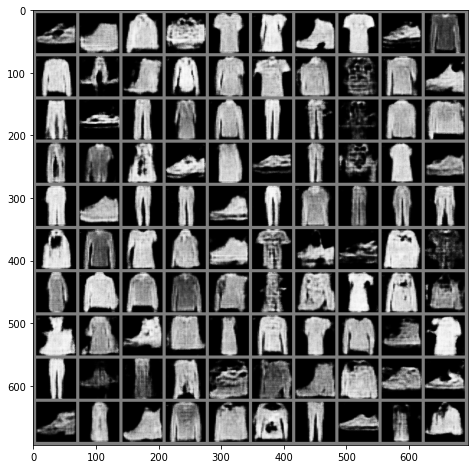

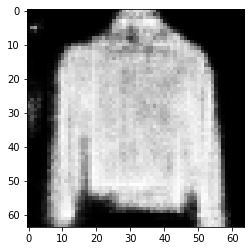

Epoch [16 / 20] average loss generator vs. discrim.: 1.591522 vs. 0.403847

Batch: 50 Generator Loss: 1.669731057882309 Discriminator Loss: 0.40103788137435914
Batch: 100 Generator Loss: 1.6282498562335967 Discriminator Loss: 0.40132092237472533
Batch: 150 Generator Loss: 1.6290462839603423 Discriminator Loss: 0.39601185083389284
Batch: 200 Generator Loss: 1.6746801662445068 Discriminator Loss: 0.39537262201309203
Batch: 250 Generator Loss: 1.6237004232406616 Discriminator Loss: 0.4046952486038208
Batch: 300 Generator Loss: 1.6492492616176606 Discriminator Loss: 0.40123907148838045
Batch: 350 Generator Loss: 1.665053024291992 Discriminator Loss: 0.40089337825775145
Batch: 400 Generator Loss: 1.6420156693458556 Discriminator Loss: 0.3958518838882446
Batch: 450 Generator Loss: 1.6751134586334229 Discriminator Loss: 0.3931472009420395


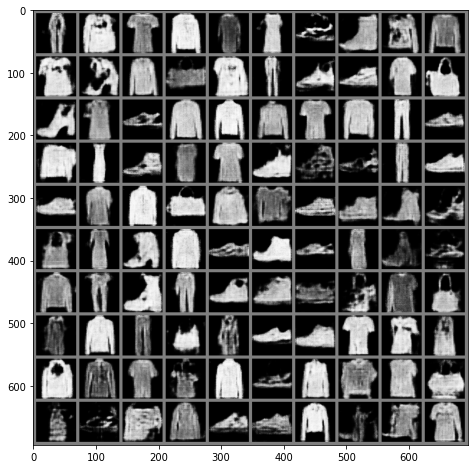

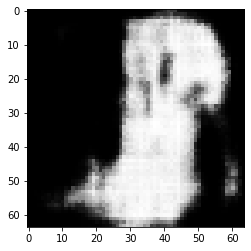

Epoch [17 / 20] average loss generator vs. discrim.: 1.651572 vs. 0.397706

Batch: 50 Generator Loss: 1.7281959271430969 Discriminator Loss: 0.38296478509902954
Batch: 100 Generator Loss: 1.7342307245731354 Discriminator Loss: 0.38652027368545533
Batch: 150 Generator Loss: 1.7095034849643707 Discriminator Loss: 0.3828312486410141
Batch: 200 Generator Loss: 1.708869354724884 Discriminator Loss: 0.38621134638786314
Batch: 250 Generator Loss: 1.74103702545166 Discriminator Loss: 0.3837087655067444
Batch: 300 Generator Loss: 1.7238120782375335 Discriminator Loss: 0.37837917983531955
Batch: 350 Generator Loss: 1.6911398470401764 Discriminator Loss: 0.4094588494300842
Batch: 400 Generator Loss: 1.7207148373126984 Discriminator Loss: 0.37172653019428253
Batch: 450 Generator Loss: 1.7709098553657532 Discriminator Loss: 0.37234640955924986


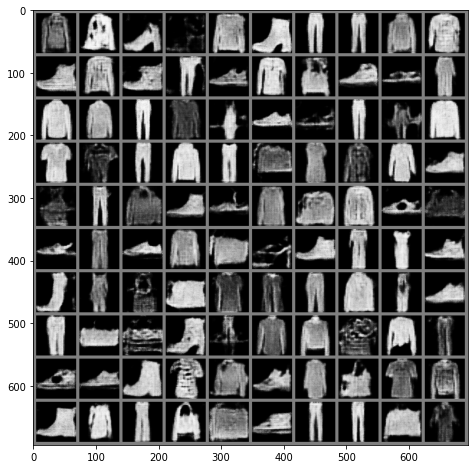

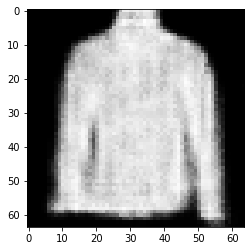

Epoch [18 / 20] average loss generator vs. discrim.: 1.728230 vs. 0.384222

Batch: 50 Generator Loss: 1.7670350348949433 Discriminator Loss: 0.37574701964855195
Batch: 100 Generator Loss: 1.754595276117325 Discriminator Loss: 0.3913312977552414
Batch: 150 Generator Loss: 1.7717005443572997 Discriminator Loss: 0.3786812901496887
Batch: 200 Generator Loss: 1.7731844830513 Discriminator Loss: 0.38293285310268405
Batch: 250 Generator Loss: 1.770130169391632 Discriminator Loss: 0.37553239583969117
Batch: 300 Generator Loss: 1.824172580242157 Discriminator Loss: 0.3650984811782837
Batch: 350 Generator Loss: 1.7715165829658508 Discriminator Loss: 0.37079827308654784
Batch: 400 Generator Loss: 1.8402385473251344 Discriminator Loss: 0.35671943008899687
Batch: 450 Generator Loss: 1.8497511625289917 Discriminator Loss: 0.36755788743495943


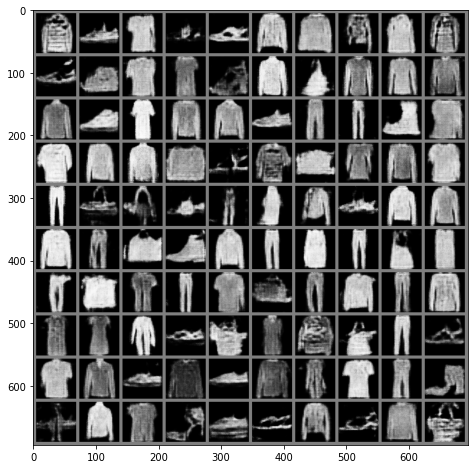

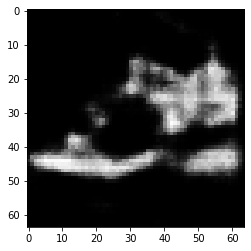

Epoch [19 / 20] average loss generator vs. discrim.: 1.788290 vs. 0.374303

Batch: 50 Generator Loss: 1.8050227975845337 Discriminator Loss: 0.3807633936405182
Batch: 100 Generator Loss: 1.856164047718048 Discriminator Loss: 0.36675585091114044
Batch: 150 Generator Loss: 1.8371398210525514 Discriminator Loss: 0.3662867844104767
Batch: 200 Generator Loss: 1.8215997171401979 Discriminator Loss: 0.37919874489307404
Batch: 250 Generator Loss: 1.8242937159538268 Discriminator Loss: 0.3703128689527512
Batch: 300 Generator Loss: 1.8245065855979918 Discriminator Loss: 0.3751645392179489
Batch: 350 Generator Loss: 1.8382267677783966 Discriminator Loss: 0.3659479945898056
Batch: 400 Generator Loss: 1.8045937669277192 Discriminator Loss: 0.3748780626058579
Batch: 450 Generator Loss: 1.8336851119995117 Discriminator Loss: 0.36706101477146147


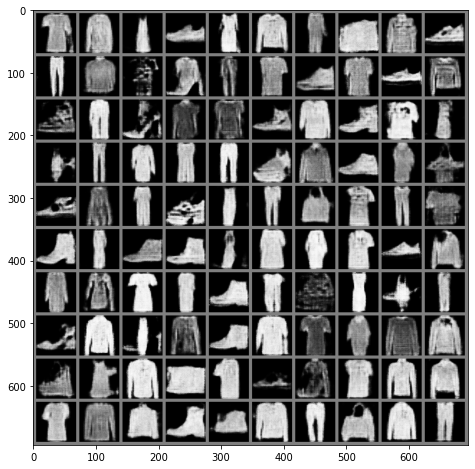

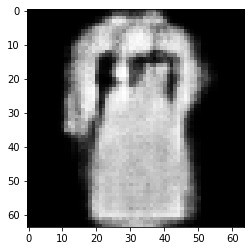

Epoch [20 / 20] average loss generator vs. discrim.: 1.827556 vs. 0.373026



In [12]:
learning_rate = 1e-5
num_epochs = 30

gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    running_loss_1 = 0.0
    running_loss_2 = 0.0

    generator.train()
    discriminator.train()
    
    for i,(image_batch, _) in enumerate(train_dataloader):
        
        image_batch = image_batch.to(device)
        k = np.random.uniform(0.05,0.15)

        label_real = torch.ones(image_batch.size(0), device=device)*(1-k)
        label_fake = torch.ones(image_batch.size(0), device=device)*k

        latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
        fake_image_batch = generator(latent)


        noise1 = torch.randn(image_batch.size(0),1,64,64, device=device) * (0.9**epoch)
        noise2 = torch.randn(image_batch.size(0),1,64,64, device=device) * (0.9**epoch)
        noisy_real_image_batch = image_batch + noise1
        noisy_fake_image_batch = fake_image_batch + noise2
        
        real_pred = discriminator(noisy_real_image_batch).squeeze()
        fake_pred = discriminator(noisy_fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        fake_pred = discriminator(noisy_fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

        running_loss_1 += gen_loss.item()
        running_loss_2 += disc_loss.item()

        if i%50 == 49:
          print("Batch:",i+1,"Generator Loss:",running_loss_1/50,"Discriminator Loss:",running_loss_2/50)
          running_loss_1 = 0.0
          running_loss_2 = 0.0
        
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches

    generator.eval()
    z = torch.randn(128, 100, 1, 1, device=device)
    epoch_pred = generator(z)
    epoch_pred = epoch_pred.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(epoch_pred.data[:100],10,5))
    plt.show()

    z = torch.randn(1, 100, 1, 1, device=device)
    epoch_pred = generator(z)
    img = epoch_pred.view(64, 64).detach().cpu().numpy()
    plt.imshow((img+1.)/2.,cmap='gray')
    plt.show()

    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %(epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))
    print("")

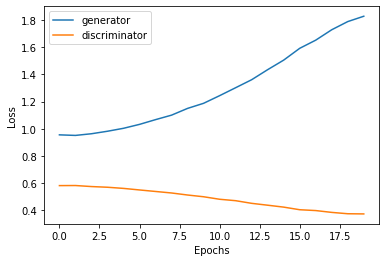

In [13]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

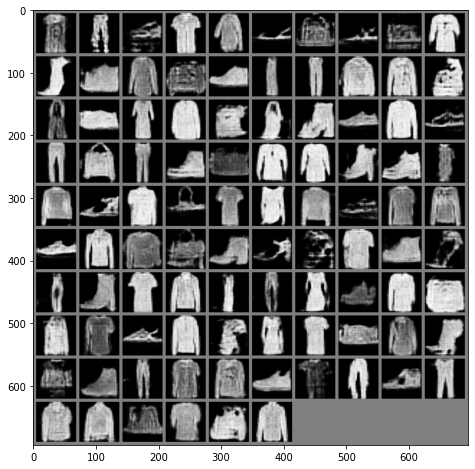

In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # sample latent vectors from the standard normal distribution
    latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
    fake_image_batch = generator(latent)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data[:100],10,5))
    plt.show()

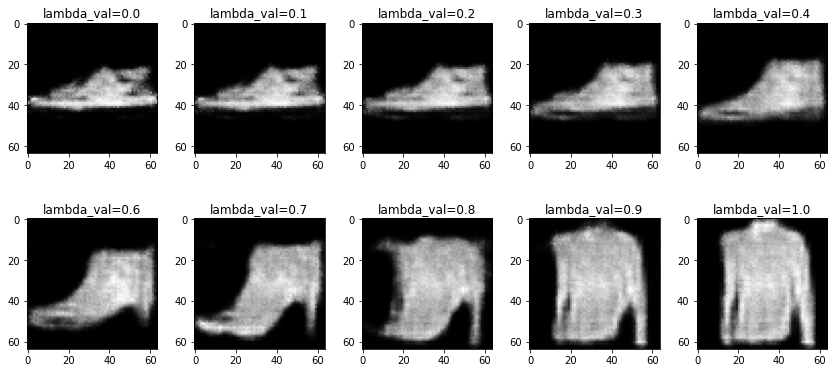

In [16]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, 100, 1, 1, device=device)
latent_2 = torch.randn(1, 100, 1, 1, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show()

In [17]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [18]:
PATH = '/content/gdrive/My Drive/Pytorch_Practice/DCGAN_FashionMNIST-2_generator.pt'
torch.save(generator,PATH)

PATH = '/content/gdrive/My Drive/Pytorch_Practice/DCGAN_FashionMNIST-2_discriminator.pt'
torch.save(discriminator,PATH)